#**Installing Required Libraries for Pneumonia Detection**

In [3]:
!pip install -r requirements.txt
!pip install tensorflow numpy matplotlib
!pip install scikit-learn opencv-python numpy matplotlib tensorflow keras


Processing /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work (from -r requirements.txt (line 2))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work'



#**Importing Required Libraries for Pneumonia Detection Model**

In [4]:
import os
import shutil
import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#**Mount Google Drive in Google Colab**

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#**Creating a Sampled Dataset for Pneumonia Detection**

In [6]:
# Define Paths
ORIGINAL_DATASET_PATH = "/content/drive/My Drive/PNEUMONIA_DETECTION/CHEST_X_RAY"
SAMPLED_DATASET_PATH = "/content/drive/My Drive/PNEUMONIA_DETECTION/CHEST_X_RAY_SAMPLED"

"""# Number of images per class
NUM_SAMPLES_TRAIN = 500  # Adjust as needed
NUM_SAMPLES_VAL = 100
NUM_SAMPLES_TEST = 100

# Function to Sample Images
def sample_images(source_folder, dest_folder, num_samples):
    os.makedirs(dest_folder, exist_ok=True)
    images = os.listdir(source_folder)
    sampled_images = random.sample(images, min(num_samples, len(images)))

    for img in sampled_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(dest_folder, img))

# Create Sampled Dataset
for category in ["NORMAL", "PNEUMONIA"]:
    os.makedirs(os.path.join(SAMPLED_DATASET_PATH, "train", category), exist_ok=True)
    os.makedirs(os.path.join(SAMPLED_DATASET_PATH, "val", category), exist_ok=True)
    os.makedirs(os.path.join(SAMPLED_DATASET_PATH, "test", category), exist_ok=True)

    # Sample images for train, val, test
    sample_images(os.path.join(ORIGINAL_DATASET_PATH, "train", category), os.path.join(SAMPLED_DATASET_PATH, "train", category), NUM_SAMPLES_TRAIN)
    sample_images(os.path.join(ORIGINAL_DATASET_PATH, "val", category), os.path.join(SAMPLED_DATASET_PATH, "val", category), NUM_SAMPLES_VAL)
    sample_images(os.path.join(ORIGINAL_DATASET_PATH, "test", category), os.path.join(SAMPLED_DATASET_PATH, "test", category), NUM_SAMPLES_TEST)
"""
print("✅ Sampled dataset created successfully!")
DATASET_PATH = SAMPLED_DATASET_PATH


✅ Sampled dataset created successfully!


#**Loading and Preprocessing the Sampled Pneumonia Dataset**

No image processing techniques used


Justification for Not Applying Extensive Image Processing in Pneumonia Detection


In medical imaging, especially for pneumonia detection from chest X-rays, it is crucial to maintain the original integrity of the images. While image processing techniques (such as contrast enhancement, blurring, or noise reduction) can improve general image clarity, they may inadvertently alter medically relevant details critical for accurate diagnosis.

In [7]:
# Update Dataset Path to Sampled Data


# Set Image Size & Batch Size
IMG_SIZE = (224, 224)  # Required for ViT
BATCH_SIZE = 16

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Only Rescale for Validation & Test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(os.path.join(DATASET_PATH, "train"),
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="binary")

val_generator = val_test_datagen.flow_from_directory(os.path.join(DATASET_PATH, "val"),
                                                     target_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode="binary")

test_generator = val_test_datagen.flow_from_directory(os.path.join(DATASET_PATH, "test"),
                                                      target_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="binary",
                                                      shuffle=False)

# Check Dataset Size
print(f"✅ Train samples: {train_generator.samples}, Validation samples: {val_generator.samples}, Test samples: {test_generator.samples}")

Found 1753 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 327 images belonging to 2 classes.
✅ Train samples: 1753, Validation samples: 16, Test samples: 327


# **Exploratory Data Analysis (EDA)**

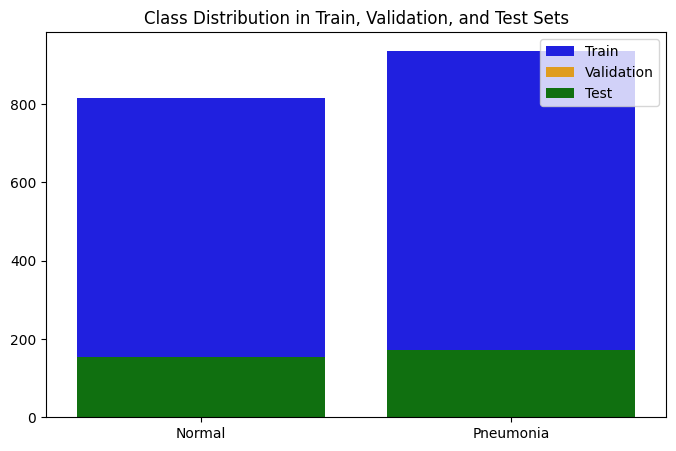

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Count images in each category
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(directory, "PNEUMONIA")))
    total = normal_count + pneumonia_count
    return normal_count, pneumonia_count, total

# Count Train, Val, Test sets
train_counts = count_images(os.path.join(DATASET_PATH, "train"))
val_counts = count_images(os.path.join(DATASET_PATH, "val"))
test_counts = count_images(os.path.join(DATASET_PATH, "test"))

# Plot Class Distribution
labels = ["Normal", "Pneumonia"]
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=train_counts[:2], label="Train", color="blue")
sns.barplot(x=labels, y=val_counts[:2], label="Validation", color="orange")
sns.barplot(x=labels, y=test_counts[:2], label="Test", color="green")
plt.legend()
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.show()


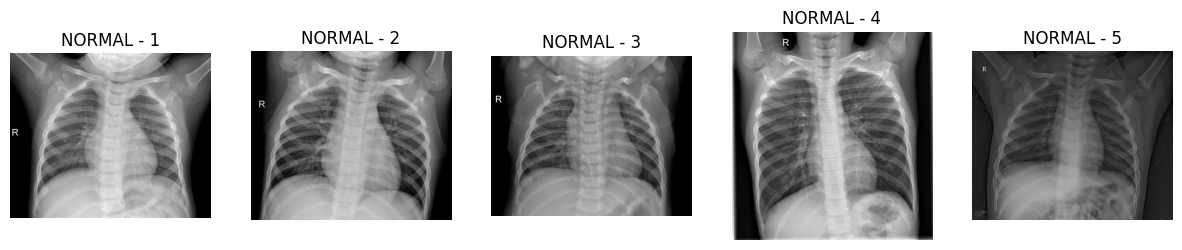

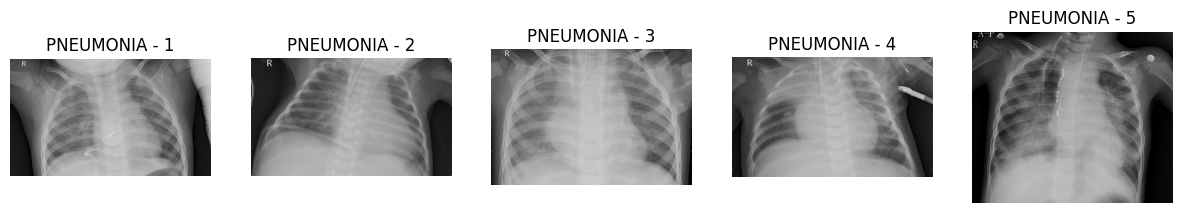

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def display_sample_images(dataset_path, category, num_images=5):
    folder_path = os.path.join(dataset_path, "train", category)
    image_files = os.listdir(folder_path)

    plt.figure(figsize=(15,5))
    for i in range(num_images):
        img_path = os.path.join(folder_path, random.choice(image_files))
        img = Image.open(img_path)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{category} - {i+1}")
        plt.axis("off")

    plt.show()

# Show NORMAL and PNEUMONIA images
display_sample_images(DATASET_PATH, "NORMAL")
display_sample_images(DATASET_PATH, "PNEUMONIA")


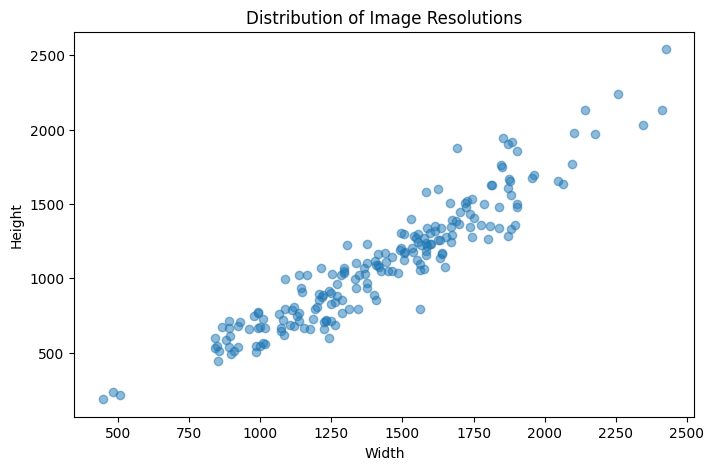

In [10]:
image_sizes = []
categories = ["NORMAL", "PNEUMONIA"]

for category in categories:
    folder_path = os.path.join(DATASET_PATH, "train", category)
    image_files = os.listdir(folder_path)

    for img_file in image_files[:100]:  # Checking first 100 images
        img = Image.open(os.path.join(folder_path, img_file))
        image_sizes.append(img.size)

# Convert to NumPy Array for Analysis
image_sizes = np.array(image_sizes)

# Scatter Plot of Image Dimensions
plt.figure(figsize=(8,5))
plt.scatter(image_sizes[:,0], image_sizes[:,1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Resolutions")
plt.show()


In [11]:
def check_corrupted_images(directory):
    corrupted_images = []
    for category in ["NORMAL", "PNEUMONIA"]:
        folder_path = os.path.join(directory, "train", category)
        for img_file in os.listdir(folder_path):
            try:
                img = Image.open(os.path.join(folder_path, img_file))  # Try opening the image
                img.verify()  # Check integrity
            except:
                corrupted_images.append(img_file)

    return corrupted_images

# Run corruption check
corrupted = check_corrupted_images(DATASET_PATH)
print("Corrupted Images Found:", corrupted)


Corrupted Images Found: []


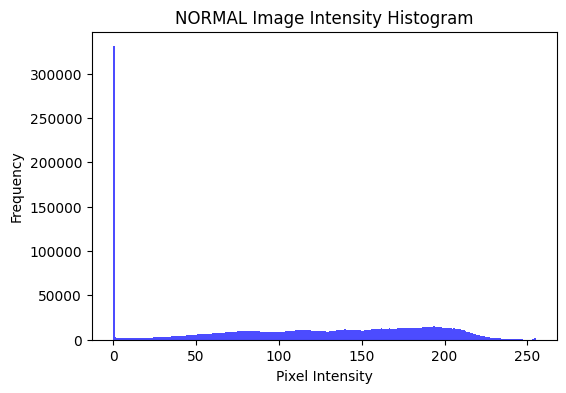

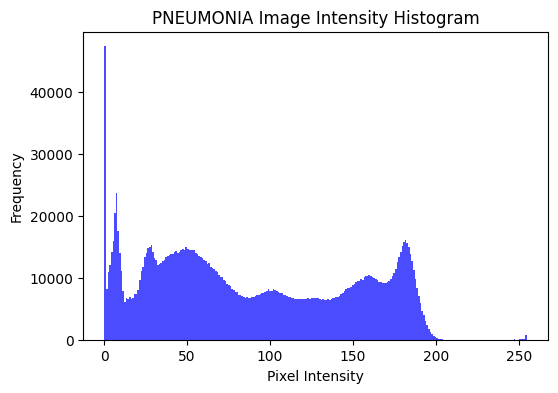

In [12]:
def plot_intensity_histogram(image_path, title):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(6,4))
    plt.hist(img.ravel(), bins=256, color="blue", alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Plot histograms for a NORMAL and PNEUMONIA image
normal_img_path = os.path.join(DATASET_PATH, "train/NORMAL", random.choice(os.listdir(os.path.join(DATASET_PATH, "train/NORMAL"))))
pneumonia_img_path = os.path.join(DATASET_PATH, "train/PNEUMONIA", random.choice(os.listdir(os.path.join(DATASET_PATH, "train/PNEUMONIA"))))

plot_intensity_histogram(normal_img_path, "NORMAL Image Intensity Histogram")
plot_intensity_histogram(pneumonia_img_path, "PNEUMONIA Image Intensity Histogram")


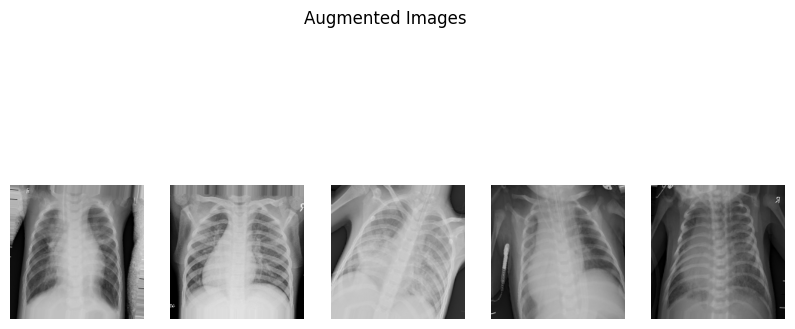

In [13]:
# Display Augmented Images
augmented_images, _ = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(augmented_images[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Augmented Images")
plt.show()


#**Feature Extraction and scaling**

In [14]:
IMG_SIZE = (224, 224)

# Load Pretrained ResNet50 Model for Feature Extraction
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Function to Load and Extract Features from Images
def load_and_extract_features(dataset_path, category):
    features = []
    labels = []
    folder_path = os.path.join(dataset_path, category)

    for label, class_name in enumerate(["NORMAL", "PNEUMONIA"]):
        class_folder = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Normalize pixel values
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Extract Features using CNN
            feature = feature_extractor.predict(img)
            features.append(feature.flatten())
            labels.append(label)

    return np.array(features), np.array(labels)

# Load Features for Training Set
X_train, y_train = load_and_extract_features(DATASET_PATH, "train")

# Load Features for Test Set
X_test, y_test = load_and_extract_features(DATASET_PATH, "test")

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Features Extracted Successfully!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━

#**MULTIPLE SUPERVISED MODELS AND ITS RESULTS**

In [15]:
# Define Multiple Models
models = {
    "Support Vector Machine (SVM)": SVC(kernel="linear"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression()
}

# Train and Evaluate Models
best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train, y_train)  # Train Model
    y_pred = model.predict(X_test)  # Make Predictions
    accuracy = accuracy_score(y_test, y_pred)  # Calculate Accuracy

    print(f"📌 {name}: Accuracy = {accuracy * 100:.2f}%")

    # Store the Best Model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

print(f"\n✅ Best Model Selected: {best_model} with Accuracy = {best_accuracy * 100:.2f}%")
# Generate Classification Report
y_pred_best = best_model.predict(X_test)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_best))


📌 Support Vector Machine (SVM): Accuracy = 73.09%
📌 Random Forest: Accuracy = 83.18%
📌 K-Nearest Neighbors (KNN): Accuracy = 83.49%
📌 Logistic Regression: Accuracy = 72.78%

✅ Best Model Selected: KNeighborsClassifier() with Accuracy = 83.49%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       155
           1       0.80      0.92      0.85       172

    accuracy                           0.83       327
   macro avg       0.84      0.83      0.83       327
weighted avg       0.84      0.83      0.83       327



#MLP model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
# Define a Simple MLP Model on Extracted Features
mlp_model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),  # Input Layer (Feature Size)
    Dropout(0.5),  # Prevent Overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # Binary Classification Output
])

# Compile the Model
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
EPOCHS = 10
history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=32)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7550 - loss: 0.5158 - val_accuracy: 0.8012 - val_loss: 0.4558
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8947 - loss: 0.2732 - val_accuracy: 0.8349 - val_loss: 0.4014
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9263 - loss: 0.1828 - val_accuracy: 0.8257 - val_loss: 0.4148
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9360 - loss: 0.1575 - val_accuracy: 0.8135 - val_loss: 0.4506
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9621 - loss: 0.1279 - val_accuracy: 0.8104 - val_loss: 0.4966
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9589 - loss: 0.1163 - val_accuracy: 0.8073 - val_loss: 0.5263
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9747 - loss: 0.0995 - val_accuracy: 0.7859 - val_loss: 0.5881
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9599 - loss: 0.1046 - val_accuracy: 0.7737 - v

#**MLP results**

In [18]:
# Make Predictions
y_pred = mlp_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert Probabilities to Binary Labels

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
✅ Test Accuracy: 75.23%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.66       155
           1       0.69      0.98      0.81       172

    accuracy                           0.75       327
   macro avg       0.82      0.74      0.73       327
weighted avg       0.81      0.75      0.74       327



In [19]:
mlp_model.save("MLP_pneumonia_detector.h5")
print("Optimized Model Saved Successfully!")


Optimized Model Saved Successfully!


#**Vit model**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



from sklearn.model_selection import train_test_split

# Split Data into Train (80%), Validation (10%), Test (10%)
X_train_vit, X_val_vit, y_train_vit, y_val_vit = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)


# Define ViT Classifier on Extracted Features
vit_model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train_vit.shape[1],)),  # Input Layer (Feature Size)
    Dropout(0.5),  # Prevent Overfitting
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # Binary Classification Output
])

# Compile the Model
vit_model.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Add Callbacks to Improve Training
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Train the Model with Validation Set
EPOCHS = 20  # Increased for better learning
history = vit_model.fit(X_train_vit, y_train_vit,
                    validation_data=(X_val_vit, y_val_vit),
                    epochs=EPOCHS, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

# Save the Model
vit_model.save("ViT_pneumonia_classifier.h5")
print("✅ ViT Model Trained & Saved Successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8298 - loss: 0.4297 - val_accuracy: 0.9375 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9276 - loss: 0.1773 - val_accuracy: 0.9318 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9477 - loss: 0.1368 - val_accuracy: 0.9545 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9662 - loss: 0.0997 - val_accuracy: 0.9375 - val_loss: 0.1687 - learning_rate: 0.0010
Epoch 5/20
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9620 - loss: 0.1074
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9621 - loss: 0.1076 - val_accuracy: 0.9545 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9744 - loss: 0.0661 - val_accu

✅ ViT Model Trained & Saved Successfully!


#**Vit Results**

In [21]:
# Make Predictions
y_pred_vit = vit_model.predict(X_test)
y_pred_vit = (y_pred_vit > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate Accuracy
accuracy_vit = accuracy_score(y_test, y_pred_vit)
print(f"✅ Test Accuracy: {accuracy_vit * 100:.2f}%")

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_vit))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
✅ Test Accuracy: 76.76%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.55      0.69       155
           1       0.70      0.97      0.81       172

    accuracy                           0.77       327
   macro avg       0.82      0.76      0.75       327
weighted avg       0.81      0.77      0.76       327



#**Model comparisons**

In [22]:
# Print All Model Accuracies
print("\n📊 Final Model Comparisons:")
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ {name}: {accuracy * 100:.2f}%")

# Print ViT Accuracy
print(f"✅ Vision Transformer: {accuracy_vit * 100:.2f}%")



📊 Final Model Comparisons:
✅ Support Vector Machine (SVM): 73.09%
✅ Random Forest: 83.18%
✅ K-Nearest Neighbors (KNN): 83.49%
✅ Logistic Regression: 72.78%
✅ Vision Transformer: 76.76%


# **DIMENSION REDUCTION TECHNIQUE**

In [23]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Apply PCA to Full Feature Set Before Splitting
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_train)  # Apply PCA before splitting

# Split Data AFTER PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_train, test_size=0.2, random_state=42)

print(f"✅ Updated Shapes - X_train_pca: {X_train_pca.shape}, y_train: {y_train_pca.shape}")


✅ Updated Shapes - X_train_pca: (1402, 158), y_train: (1402,)


# **Optimization of hyper-parameters**

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define Hyperparameter Grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train_pca)

print("✅ Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define Hyperparameter Distribution
param_dist = {
    "n_neighbors": np.arange(1, 21),
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# Perform Random Search
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train_pca, y_train_pca)

print("✅ Best KNN Parameters:", random_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Best KNN Parameters: {'n_neighbors': np.int64(11), 'metric': 'manhattan'}


# **Development of the model with the optimized parameters.**

✅ Optimized Random Forest Accuracy: 88.60%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       170
           1       0.93      0.85      0.88       181

    accuracy                           0.89       351
   macro avg       0.89      0.89      0.89       351
weighted avg       0.89      0.89      0.89       351



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


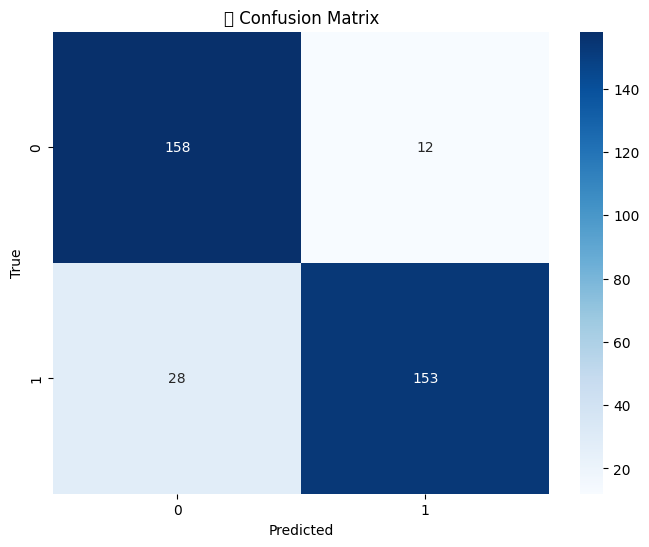

<ipython-input-26-cae2ef78b536>:82: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


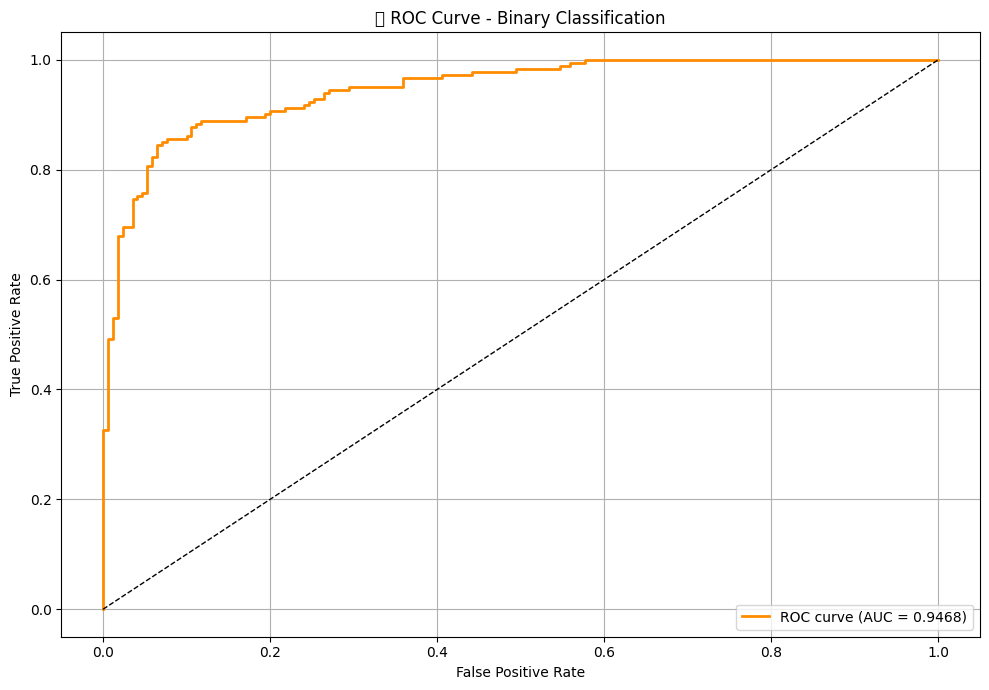

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optimized Random Forest Model
optimized_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5
)

# Train the Model
optimized_rf.fit(X_train_pca, y_train_pca)

# Evaluate the Model
rf_acc = optimized_rf.score(X_test_pca, y_test_pca)
print(f"✅ Optimized Random Forest Accuracy: {rf_acc * 100:.2f}%")

# ==== Precision, Recall, F1-Score ====
y_pred = optimized_rf.predict(X_test_pca)
print("\n📊 Classification Report:")
print(classification_report(y_test_pca, y_pred))

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test_pca, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_pca), yticklabels=np.unique(y_test_pca))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📉 Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==== ROC-AUC and Curve ====
classes = np.unique(y_test_pca)
y_score = optimized_rf.predict_proba(X_test_pca)

plt.figure(figsize=(10, 7))

if len(classes) == 2:
    # ✅ Binary Classification
    fpr, tpr, _ = roc_curve(y_test_pca, y_score[:, 1])
    roc_auc = roc_auc_score(y_test_pca, y_score[:, 1])

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.title("📉 ROC Curve - Binary Classification")

else:
    # ✅ Multi-Class Classification
    y_test_bin = label_binarize(y_test_pca, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.title("📉 ROC Curve - Multi-class (OvR)")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

import joblib
import h5py
import pickle
import numpy as np
from google.colab import files

# === Save as .pkl ===
joblib.dump(optimized_rf, "pneumonia_rf_model.pkl")

# === Save as .h5 (optional method for sklearn models using h5py) ===
model_bytes = pickle.dumps(optimized_rf)
with h5py.File('pneumonia_rf_model.h5', 'w') as f:
    f.create_dataset('model', data=np.void(model_bytes))

# === Download both files ===
files.download("pneumonia_rf_model.pkl")
files.download("pneumonia_rf_model.h5")


✅ Optimized KNN Accuracy: 90.60%

📊 Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       170
           1       0.95      0.87      0.90       181

    accuracy                           0.91       351
   macro avg       0.91      0.91      0.91       351
weighted avg       0.91      0.91      0.91       351



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


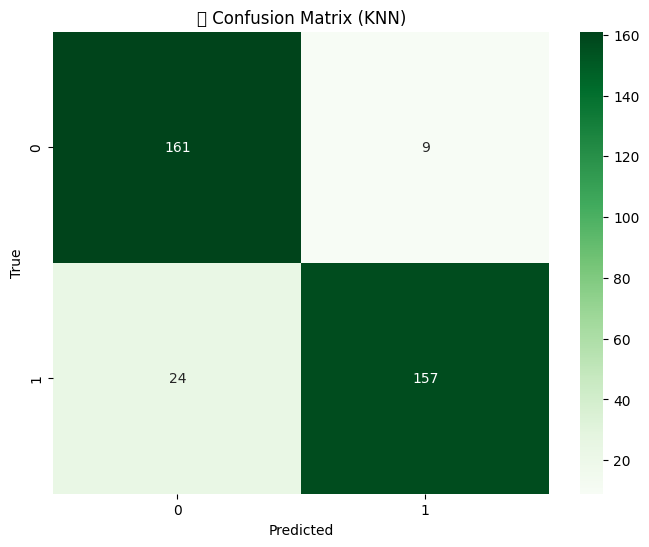

<ipython-input-27-562ea2fbaa77>:77: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


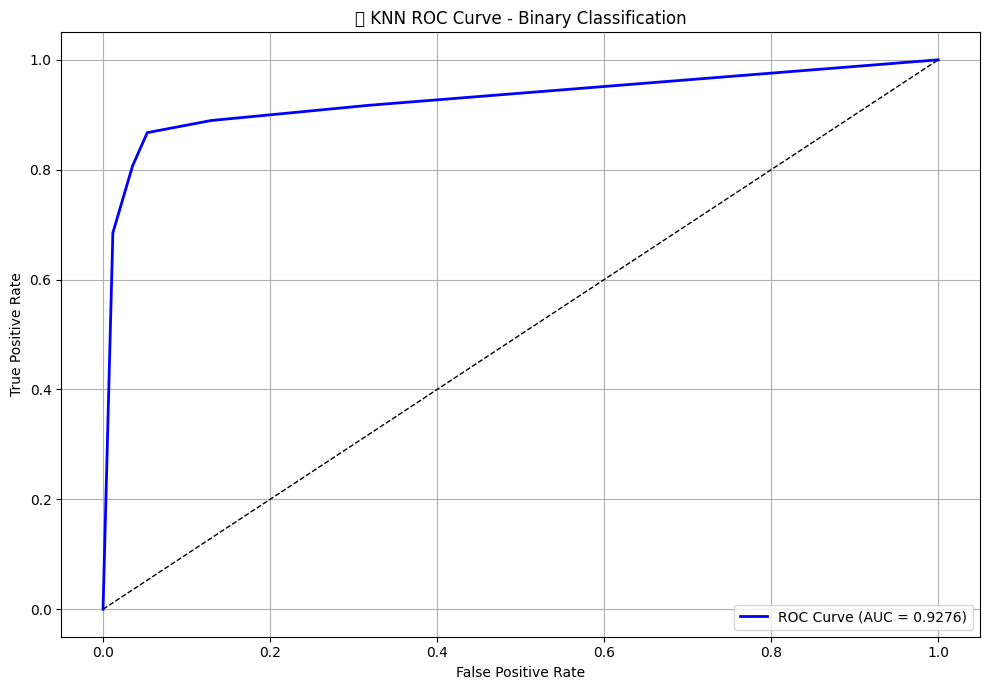

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optimized KNN Model
optimized_knn = KNeighborsClassifier(
    n_neighbors=5,
    metric="manhattan"
)

# Train the Model
optimized_knn.fit(X_train_pca, y_train_pca)

# Evaluate the Model
knn_acc = optimized_knn.score(X_test_pca, y_test_pca)
print(f"✅ Optimized KNN Accuracy: {knn_acc * 100:.2f}%")

# ==== Precision, Recall, F1-Score ====
y_pred_knn = optimized_knn.predict(X_test_pca)
print("\n📊 Classification Report (KNN):")
print(classification_report(y_test_pca, y_pred_knn))

# ==== Confusion Matrix ====
cm_knn = confusion_matrix(y_test_pca, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y_test_pca), yticklabels=np.unique(y_test_pca))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📉 Confusion Matrix (KNN)")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==== ROC-AUC Score & Curve for KNN ====
classes = np.unique(y_test_pca)
y_score_knn = optimized_knn.predict_proba(X_test_pca)

plt.figure(figsize=(10, 7))

if len(classes) == 2:
    # ✅ Binary classification
    fpr, tpr, _ = roc_curve(y_test_pca, y_score_knn[:, 1])
    roc_auc_knn = roc_auc_score(y_test_pca, y_score_knn[:, 1])

    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f"ROC Curve (AUC = {roc_auc_knn:.4f})")
    plt.title("📉 KNN ROC Curve - Binary Classification")

else:
    # ✅ Multi-class classification
    y_test_bin_knn = label_binarize(y_test_pca, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc_knn = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin_knn[:, i], y_score_knn[:, i])
        roc_auc_knn[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Class {classes[i]} (AUC = {roc_auc_knn[i]:.2f})")

    macro_auc = roc_auc_score(y_test_bin_knn, y_score_knn, average="macro", multi_class="ovr")
    plt.title(f"📉 KNN ROC Curve - Multi-class (OvR)\nMacro AUC = {macro_auc:.4f}")

# Common plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

import joblib      # For saving/loading sklearn models as .pkl
import pickle

import joblib
import h5py
import pickle
import numpy as np
from google.colab import files

# === Save as .pkl ===
joblib.dump(optimized_knn, "pneumonia_knn_model.pkl")

# === Save as .h5 (optional method for sklearn models using h5py) ===
model_bytes = pickle.dumps(optimized_knn)
with h5py.File('pneumonia_knn_model.h5', 'w') as f:
    f.create_dataset('model', data=np.void(model_bytes))

# === Download both files ===
files.download("pneumonia_knn_model.pkl")
files.download("pneumonia_knn_model.h5")



Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9824 - loss: 0.0644 - val_accuracy: 0.9659 - val_loss: 0.1207
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9822 - loss: 0.0395 - val_accuracy: 0.9602 - val_loss: 0.1324
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9830 - loss: 0.0413 - val_accuracy: 0.9716 - val_loss: 0.1484
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9863 - loss: 0.0280 - val_accuracy: 0.9716 - val_loss: 0.1243
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9859 - loss: 0.0323 - val_accuracy: 0.9659 - val_loss: 0.1333
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9716 - val_loss: 0.1287
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9807 - loss: 0.0463 - val_accuracy: 0.9716 - val_loss: 0.1280
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9902 - loss: 0.0261 - val_accuracy: 0.9716 - v

<ipython-input-28-c3b0971d24a7>:51: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


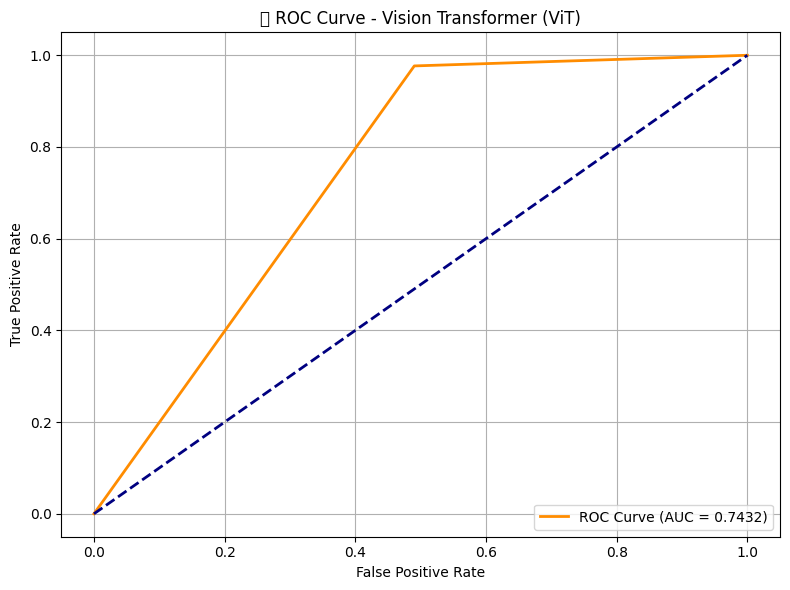

'\n# Evaluate Model\ntest_loss, vit_acc = vit_model.evaluate(X_test)\nprint(f"✅ Optimized ViT Accuracy: {vit_acc * 100:.2f}%")\n'

In [28]:
from tensorflow.keras.optimizers import Adam

# Fine-Tune ViT Model
vit_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Optimized LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train with Optimized Hyperparameters
history = vit_model.fit(
    X_train_vit, y_train_vit,
    validation_data=(X_val_vit, y_val_vit),
    epochs=15,  # More training for better feature learning
    batch_size=32
)


# Make Predictions
y_pred_vit = vit_model.predict(X_test)
y_pred_vit = (y_pred_vit > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate Accuracy
accuracy_vit = accuracy_score(y_test, y_pred_vit)
print(f"✅ Test Accuracy: {accuracy_vit * 100:.2f}%")

# Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_vit))
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# ==== ROC-AUC Score ====
# Assuming y_test is binary (0/1)
roc_auc_vit = roc_auc_score(y_test, y_pred_vit)
print(f"\n🚀 ROC-AUC Score (ViT): {roc_auc_vit:.4f}")

# ==== ROC Curve ====
fpr, tpr, _ = roc_curve(y_test, y_pred_vit)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📉 ROC Curve - Vision Transformer (ViT)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

"""
# Evaluate Model
test_loss, vit_acc = vit_model.evaluate(X_test)
print(f"✅ Optimized ViT Accuracy: {vit_acc * 100:.2f}%")
"""

# **ENSEMBLE MODEL**

Processing /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work (from -r requirements.txt (line 2))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work'

🎯 Ensemble Model Accuracy: 92.59%

📊 Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       170
           1       0.95      0.91      0.93       181

    accuracy                           0.93       351
   macro avg       0.93      0.93      0.93       351
weighted avg       0.93      0.93      0.93       351



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


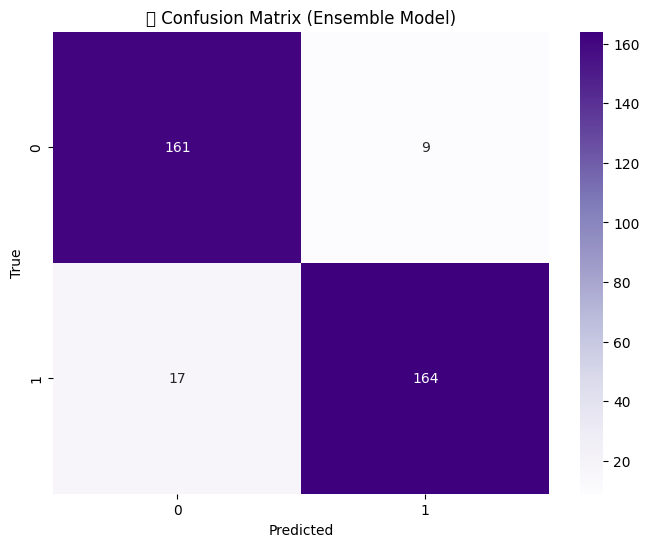

<ipython-input-32-22b6160547cf>:97: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


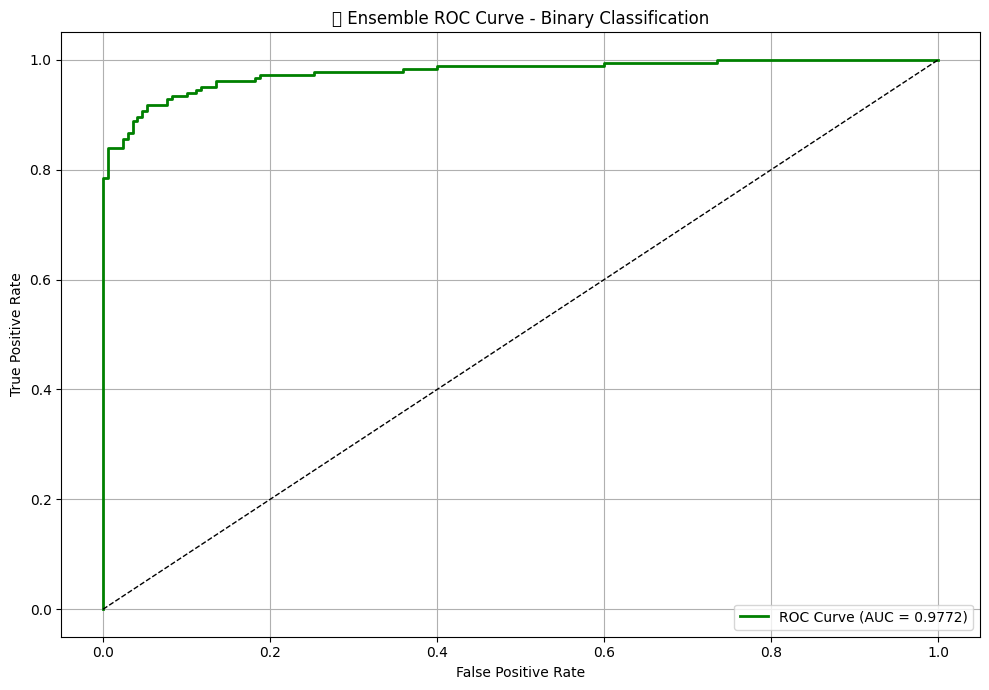

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:

!pip install -r requirements.txt


from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Individual optimized classifiers
knn = KNeighborsClassifier(n_neighbors=5, metric="manhattan")
rf = RandomForestClassifier(n_estimators=200, max_depth=10)
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1)
svm = SVC(probability=True, kernel='rbf', C=10)
logreg = LogisticRegression(max_iter=500)

# Ensemble Model using Soft Voting
ensemble_model = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('rf', rf),
        ('gb', gb),
        ('svm', svm),
        ('logreg', logreg)
    ],
    voting='soft'
)

# Train the ensemble
ensemble_model.fit(X_train_pca, y_train_pca)

# Predict and evaluate
y_pred_ensemble = ensemble_model.predict(X_test_pca)
ensemble_acc = accuracy_score(y_test_pca, y_pred_ensemble)
print(f"🎯 Ensemble Model Accuracy: {ensemble_acc * 100:.2f}%")

# ==== Classification Report ====
print("\n📊 Classification Report (Ensemble):")
print(classification_report(y_test_pca, y_pred_ensemble))

# ==== Confusion Matrix ====
cm_ensemble = confusion_matrix(y_test_pca, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Purples', xticklabels=np.unique(y_test_pca), yticklabels=np.unique(y_test_pca))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📉 Confusion Matrix (Ensemble Model)")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==== ROC-AUC Score & Curve for Ensemble Model ====
classes = np.unique(y_test_pca)
y_score_ensemble = ensemble_model.predict_proba(X_test_pca)

plt.figure(figsize=(10, 7))

if len(classes) == 2:
    # ✅ Binary classification
    fpr, tpr, _ = roc_curve(y_test_pca, y_score_ensemble[:, 1])
    roc_auc_ensemble = roc_auc_score(y_test_pca, y_score_ensemble[:, 1])

    plt.plot(fpr, tpr, color='green', lw=2,
             label=f"ROC Curve (AUC = {roc_auc_ensemble:.4f})")
    plt.title("📉 Ensemble ROC Curve - Binary Classification")

else:
    # ✅ Multi-class classification
    y_test_bin_ensemble = label_binarize(y_test_pca, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc_ensemble = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin_ensemble[:, i], y_score_ensemble[:, i])
        roc_auc_ensemble[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Class {classes[i]} (AUC = {roc_auc_ensemble[i]:.2f})")

    macro_auc = roc_auc_score(y_test_bin_ensemble, y_score_ensemble, average="macro", multi_class="ovr")
    plt.title(f"📉 Ensemble ROC Curve - Multi-class (OvR)\nMacro AUC = {macro_auc:.4f}")

# Common plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

import joblib
import h5py
import pickle
import numpy as np
from google.colab import files


# === Save as .pkl ===
joblib.dump(ensemble_model, "pneumonia_ensemble_model.pkl")

# === Save as .h5 (optional method for sklearn models using h5py) ===
model_bytes = pickle.dumps(ensemble_model)
with h5py.File('pneumonia_ensemble_model.h5', 'w') as f:
    f.create_dataset('model', data=np.void(model_bytes))

# === Download both files ===
files.download("pneumonia_ensemble_model.pkl")
files.download("pneumonia_ensemble_model.h5")




In [33]:
import numpy
import pandas
import sklearn

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Scikit-learn version:", sklearn.__version__)
import joblib
print(joblib.__version__)



NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn version: 1.6.1
1.4.2


In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use accuracy as the scoring metric
cv_scores = cross_val_score(ensemble_model, X_train_pca, y_train_pca, cv=kfold, scoring='accuracy')

print("🧪 K-Fold Cross Validation Results:")
print(f"Fold-wise Accuracies: {cv_scores}")
print(f"Mean Accuracy     : {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


🧪 K-Fold Cross Validation Results:
Fold-wise Accuracies: [0.95017794 0.94661922 0.97142857 0.94285714 0.97142857]
Mean Accuracy     : 0.9565
Standard Deviation: 0.0124
